In [1]:
# GAN : 적대적 생성 신경망 + CNN   DCGAN
# 생성모델(G)  식별모델 D
# G : k차원의 잠재적 특이 벡터를 입력값으로 받아서 대상과 동일형식의 데이터를 생셩하는 신경망
# D : 대상데이터를 입력값으로 받아 진위를식별하는 신경망

In [2]:
# GAN
# 1. 잠재적 특이 벡터 z를 난수로  생성하고 G(z)를 사용해 가짜 데이터(fake data)를 생성  fake_data <-- G(z)
# 2. fake_data를 D로식별한다  fake_data<-- D(real_data)
# 3. 진짜 데이터의 샘플(real_data)을 D로  식별한다  real_out<--- D(real_data)
# 4. fake_out 이 진짜 데이터라고 간주하고 크로스 엔트로피함수를 계산해서 G의 파라메터를  갱신
# 5. real_out이 진짜 데이터이고 fake_out이 가짜 데이터라고 간주하고 크로스 엔트로피 함수를 계산해서 D의 파라메터를 갱신

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!tar -zxvf 102flowers.tgz

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
jpg/image_02266.jpg
jpg/image_00062.jpg
jpg/image_05821.jpg
jpg/image_03712.jpg
jpg/image_01142.jpg
jpg/image_03033.jpg
jpg/image_05760.jpg
jpg/image_02732.jpg
jpg/image_00183.jpg
jpg/image_05264.jpg
jpg/image_03778.jpg
jpg/image_07061.jpg
jpg/image_04468.jpg
jpg/image_00676.jpg
jpg/image_07610.jpg
jpg/image_02192.jpg
jpg/image_05112.jpg
jpg/image_05638.jpg
jpg/image_00053.jpg
jpg/image_02451.jpg
jpg/image_05857.jpg
jpg/image_08033.jpg
jpg/image_03902.jpg
jpg/image_07494.jpg
jpg/image_02357.jpg
jpg/image_05496.jpg
jpg/image_04496.jpg
jpg/image_07538.jpg
jpg/image_01801.jpg
jpg/image_00326.jpg
jpg/image_07644.jpg
jpg/image_01199.jpg
jpg/image_01168.jpg
jpg/image_07020.jpg
jpg/image_05006.jpg
jpg/image_03484.jpg
jpg/image_02825.jpg
jpg/image_04549.jpg
jpg/image_02011.jpg
jpg/image_04360.jpg
jpg/image_06847.jpg
jpg/image_07695.jpg
jpg/image_03540.jpg
jpg/image_08058.jpg
jpg/image_01230.jpg
jpg/image_00096.jpg
jpg/image_01517.jpg
jpg/image_07640.jpg
jpg/

In [4]:
!mkdir oxford-102
!mkdir oxford-102/jpg
!mv jpg/*.jpg oxford-102/jpg

In [5]:
!rmdir jpg

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,TensorDataset
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from torchvision.datasets import ImageFolder

In [7]:
img_data = ImageFolder('/content/oxford-102',
                       transform=transforms.Compose([
                           transforms.Resize(80),
                           transforms.CenterCrop(64),
                           transforms.ToTensor()
                       ])
                       )
batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size, shuffle=True)

In [8]:
# data,label = next(iter(img_loader))

In [9]:
# data.shape, label

In [54]:
# 잠재적 특이 벡터 z를 100차원으로 만든, z  3 x 64 x 64 의 이미지를 만드는 생성모델을 구축
# ConvTransposed2d
nz = 100
ngf = 32
class GNet(nn.Module):
  def __init__(self):
    super(GNet, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, ngf*8, 4,1,0,bias=False  ), # 출력값에 편항을 추가하지 않아서 더 간단한 모델을 구현
        nn.BatchNorm2d(ngf*8),
        nn.ReLU(inplace=True), # 출력값을 새로운 변수에 할당하지 않고 기존의 변수에 덮어쓴다.  메모리 사용량을 줄인다
        
        nn.ConvTranspose2d(ngf*8, ngf*4, 4,2,1,bias=False),
        nn.BatchNorm2d(ngf*4),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(ngf*4, ngf*2, 4,2,1,bias=False),
        nn.BatchNorm2d(ngf*2),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(ngf*2, ngf, 4,2,1,bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(ngf, 3, 4,2,1,bias=False),
        nn.Tanh()
    )
  def forward(self, x):
    return self.main(x)

In [55]:
# 식별모델은 3 x 64 x 64 이미지를 최종적으로 1차원 스칼라로 변환하는 신경망
# 원래 논문에서 선형 계층을 사용하지 않음

ndf = 32
class DNet(nn.Module):
  def __init__(self) -> None:
    super(DNet,self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(3,ndf, 4,2,1,bias=False),
        nn.LeakyReLU(0.2,inplace=True),       

        nn.Conv2d(ndf,ndf*2, 4,2,1,bias=False),
        nn.BatchNorm2d(ndf*2),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*2,ndf*4, 4,2,1,bias=False),
        nn.BatchNorm2d(ndf*4),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*4,ndf*8, 4,2,1,bias=False),
        nn.BatchNorm2d(ndf*8),
        nn.LeakyReLU(0.2,inplace=True),

        nn.Conv2d(ndf*8,1, 4,2,1,bias=False)
    )
  def forward(self, x):
    return self.main(x).squeeze()

In [56]:
# 5번 합성곱 연산을해서 3 x 64 x64 이미지가 최종적으로 1 x 1x 1이 된다. 
# A x 1 x B x1 불필요한 1이 들어있는 shape를 A x B 처럼 조정
# Conv2d 는 입력과 출력 모두(batch_size, channel, height, width)  -- (batch_size,1,1,1)--> 불필요한 차원을 삭제

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
d = DNet().to(device)
g = GNet().to(device)

In [58]:
#DCGAN 원 논문에 기술되어 있는 파라메터 값
opt_d = optim.Adam(d.parameters(), lr = 0.0002,betas=(0.5,0.999))
opt_g = optim.Adam(g.parameters(), lr = 0.0002,betas=(0.5,0.999))

# 크로스 엔트로피를 계산하기 위한 보조 변수
ones = torch.ones((batch_size,2,2)).to(device)
zeros = torch.zeros((batch_size,2,2)).to(device)
loss_f = nn.BCEWithLogitsLoss()  # 출력값을 logit으로 변환하여 시그모이들 함수를 적용한다음 binary cross entropy손실을 계산
# logit : 0.5를 임계치로 삼아서. 양성 음성 클래스 변환
# 로짓함수의 수식은 : logit(p) = log(p / (1 - p))   p는 0과 1사이의 확률

# 모니터링용 Z
fixed_z = torch.randn(batch_size, nz,1,1).to(device)

In [59]:
# 훈련함수
import numpy as np
import tqdm
def train_dcgan(g,d,opt_g, opt_d, loader):
  # 생성모델, 식별 모델의 목적 함수 추적용 배열
  log_loss_g = []
  log_loss_d = []
  for real_img, _ in tqdm.tqdm(loader):
    batch_len = len(real_img)
    # 실제이미지를 gpu로 복사
    real_img = real_img.to(device)
    #가짜 이미지를 난수와 생성 모델을 사용해 만든다
    z = torch.randn(batch_len, nz, 1,1).to(device)
    # print('1*******************')
    fake_img = g(z)
    # 나중에 사용하기 위해서 가짜 이미지의 값만 별도로 저장
    fake_img_tensor = fake_img.detach()
    # 가짜 이미지에 대해 생성 모델의 평가 함수 계산
    # print('2******************', fake_img.shape)
    out = d(fake_img)
    # print('3******************',out.shape, ones[:batch_len].shape)
    loss_g = loss_f(out, ones[:batch_len])
    log_loss_g.append(loss_g.item())
    # 계산그래프가 생성모델과 식별 모델 양쪽에 의존하므로 양쪽모두 경사하강을 끝낸 후에
    # 미분 계산과 파라미터 갱신을 실시
    # print('4******************')
    opt_g.zero_grad(), opt_d.zero_grad()
    # print('5******************')
    loss_g.backward()
    # print('6******************')
    opt_g.step()

    # 실제 이미지에 대한 식별 모델의 평가함수 계산
    # print('7******************')
    real_out = d(real_img)
    # print('8******************')
    loss_d_real = loss_f(real_out, ones[:batch_len])

    # 파이토치에선 동일 Tensor를 포함한 계산 그래프에 2회 backward를 할 수 없으므로 저장된 tensor를
    # 사용해서 불필요한 계산은 생략
    fake_img = fake_img_tensor

    #가짜 이미지에 대한 식별 모델의 평가 함수 계산
    # print('9******************')
    fake_out = d(fake_img_tensor)
    # print('10******************')
    loss_d_fake = loss_f(fake_out, zeros[:batch_len])

    #진위평가 함수 합계
    loss_d = loss_d_real + loss_d_fake
    log_loss_d.append(loss_d.item())

    # 식별 모델의 미분 계사니과 파라미터 갱신
    # print('11******************')
    opt_g.zero_grad(), opt_d.zero_grad()
    # print('12******************')
    loss_d.backward()
    # print('13******************')
    opt_d.step()
  return np.mean(log_loss_g), np.mean(log_loss_d)

In [60]:
data,label = next(iter(img_loader))
data.shape

torch.Size([64, 3, 64, 64])

In [61]:
from torchvision.utils import save_image
# 원래는 300번 정도
for epoch in range(16):
  train_dcgan(g, d, opt_g, opt_d,img_loader)
  # 10회마다 학습 결과를 저장
  if epoch % 5 == 0:
    # 파라메터 저장
    torch.save(
      g.state_dict(),
      f'g_{epoch:03d}',
      pickle_protocol=4    #  pickle프로토콜 버전을 지정, 객체 직렬화를 위해서 ,모델 파라메터를 직렬화 할때
    )
    torch.save(
      d.state_dict(),
      f'd_{epoch:03d}',
      pickle_protocol=4    #  pickle프로토콜 버전을 지정, 객체 직렬화를 위해서 ,모델 파라메터를 직렬화 할때
    )
    # 모니터링용 z로부터 생성한 이미지 저장
    generated_img = g(fixed_z)
    save_image(generated_img, f'./{epoch:03d}.jpg')

100%|██████████| 128/128 [00:59<00:00,  2.14it/s]


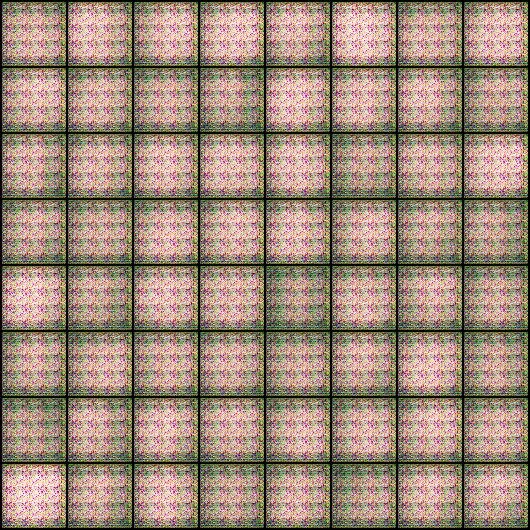

In [62]:
from IPython.display import Image, display_jpeg
display_jpeg(Image('./000.jpg'))

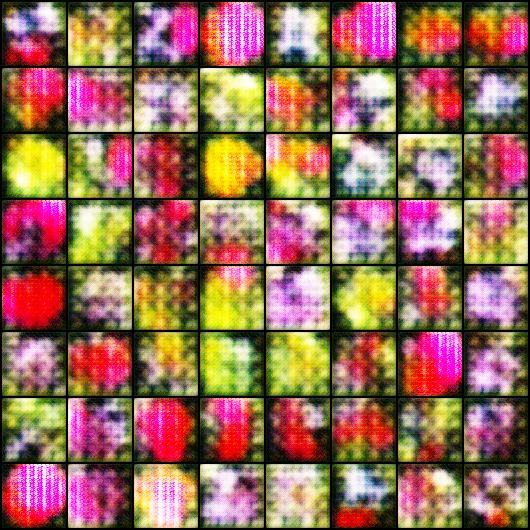

In [63]:
display_jpeg(Image('./005.jpg'))

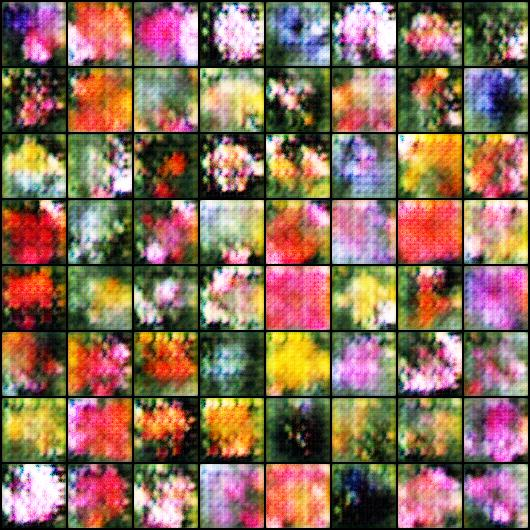

In [64]:
display_jpeg(Image('./010.jpg'))

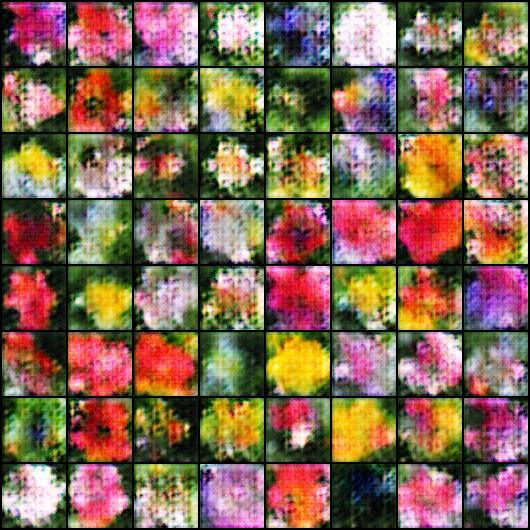

In [65]:
display_jpeg(Image('./015.jpg'))